In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

from tensorflow.keras import Model

from epi.normalizing_flows import Arch

print(tf.__version__)
# Mac OS jupyter kernel dies without
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

2.1.0


In [2]:
class Parameter:
    def __init__(self, name, bounds=(np.NINF, np.PINF)):
        if (type(name) is not str):
            raise TypeError('Parameter name arg must be a string not %s.' % type(name))
        self.set_name(name)
        self.set_bounds(bounds)
        
    def set_name(self, name):
        if (type(name) is not str):
            raise TypeError('Parameter name arg must be a string not %s.' % type(name))
        self.name = name
        
    def set_bounds(self, bounds):
        if (type(bounds) in [list, tuple]):
            len_bounds = len(bounds)
        elif (type(bounds) is np.ndarray):
            len_bounds = bounds.shape[0]
            bounds = [bounds[0], bounds[1]]
        else:
            raise TypeError('Parameter bounds arg must be tuple, list, or numpy array.')
        
        if (len_bounds != 2):
            raise ValueError('Parameter bounds arg must be length 2.')
            
        self.bounds = bounds
        

class Model:
    def __init__(self, name, parameters):
        self.name = name
        self.parameters = parameters
        if not self.parameter_check(verbose=True):
            raise ValueError('Invalid parameter list.')
        self.eps = lambda : None
        
    def set_name(self, name):
        self.name = name
        
    def set_parameters(self, parameters):
        self.parameters = parameters
    
    def set_eps():
        raise NotImplementedError()
        
    def epi():
        raise NotImplementedError()
        
    def load_epi_dist():
        raise NotImplementedError()
        
    def parameter_check(self, verbose=False):
        d = dict()
        for param in self.parameters:
            name = param.name
            if (name in d):
                if (verbose):
                    print('Warning: Duplicate parameter %s in Model.parameters.' % name)
                return False
            else:
                d[name] = True
            
            bounds = param.bounds
            if (bounds[0] == bounds[1]):
                if (verbose):
                    print('Warning: Left bound equal to right bound for parameter %s.' % name)
                return False
            elif (bounds[0] > bounds[1]):
                if (verbose):
                    print('Warning: Left bound greater than right bound for parameter %s.' % name)
                return False
            
        return True

In [3]:
A = Arch('planar', 2)
print(A.to_string())

2_planar_PA


In [20]:
def gaussian_eta(mu, Sigma):
    n = mu.shape[0]
    Sigma_inv = np.linalg.inv(Sigma)
    x = np.dot(Sigma_inv, mu)
    y = np.reshape(-0.5*Sigma_inv, (n**2))
    eta = np.concatenate((x[:,0], y), 
                         axis=0)
    return eta

N = 200
mu = 0.0*np.ones((4,1))
Sigma = np.eye(4)
Sigma[1,2] = 0.8
Sigma[2,1] = 0.8

arch = CouplingArch(4, 1, 2, 10, True)
optimizer = tf.keras.optimizers.Adam(1e-1)

def train_step():
    n = mu.shape[0]
    eta = gaussian_eta(mu, Sigma)
    with tf.GradientTape() as tape:
        x, log_q_x = arch(N)
        xl = x[:,:,tf.newaxis]
        xr = x[:,tf.newaxis,:]
        xxT = tf.matmul(xl, xr)
        xxT_vec = tf.reshape(xxT, (N,n**2))
        T_x = tf.concat((x, xxT_vec), axis=1)
        E_T_x = tf.reduce_mean(T_x, axis=0)
        
        H = tf.reduce_mean(-log_q_x)
        loss = -H + - tf.reduce_sum(eta*E_T_x)
    
    params = arch.trainable_variables
    gradients = tape.gradient(loss, params)
        
    optimizer.apply_gradients(zip(gradients, params))
    return loss


0 tf.Tensor(-1.312758, shape=(), dtype=float32) took 0.0434 seconds


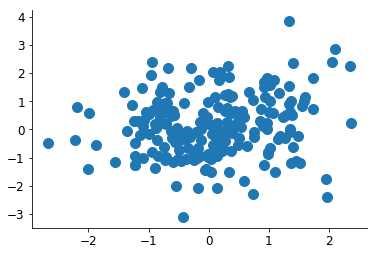

100 tf.Tensor(-2.465166, shape=(), dtype=float32) took 0.0228 seconds


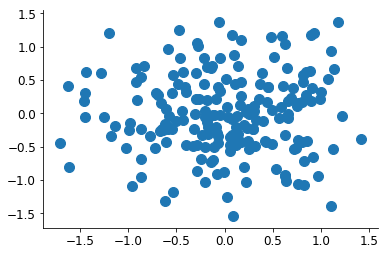

200 tf.Tensor(-2.6702197, shape=(), dtype=float32) took 0.0241 seconds


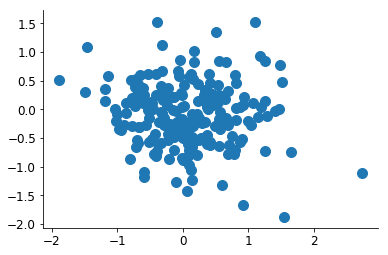

300 tf.Tensor(-2.5244026, shape=(), dtype=float32) took 0.0231 seconds


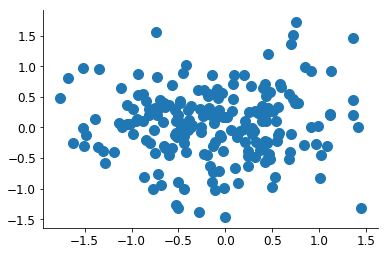

400 tf.Tensor(-2.5240943, shape=(), dtype=float32) took 0.0239 seconds


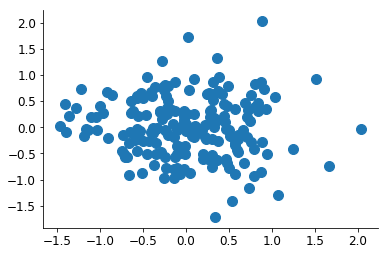

500 tf.Tensor(-2.5899272, shape=(), dtype=float32) took 0.0228 seconds


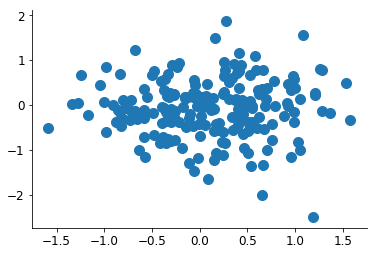

600 tf.Tensor(-2.5045867, shape=(), dtype=float32) took 0.0236 seconds


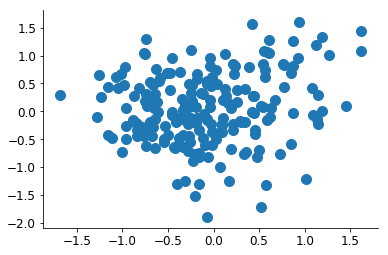

700 tf.Tensor(-2.477463, shape=(), dtype=float32) took 0.0239 seconds


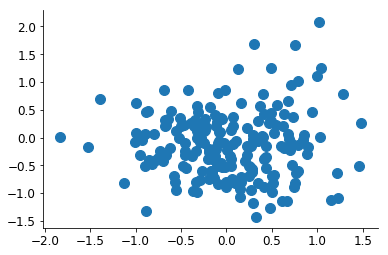

800 tf.Tensor(-2.5693655, shape=(), dtype=float32) took 0.0246 seconds


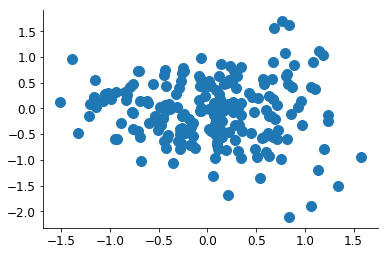

900 tf.Tensor(-2.4721174, shape=(), dtype=float32) took 0.0250 seconds


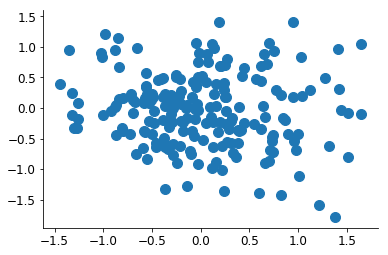

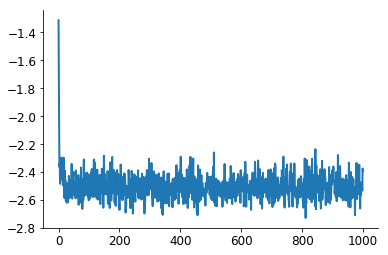

In [21]:
num_iters = 1000
losses = np.zeros((num_iters))
for i in range(num_iters):
    start_time = time.time()
    loss = train_step()
    losses[i] = loss
    end_time = time.time()
    if (i % 100 == 0):
        print(i, loss, 'took %.4f seconds' % (end_time-start_time))
        x, log_q_x = arch(N)
        plt.figure()
        plt.scatter(x[:,1], x[:,2]) # c=dn.log_prob(x))
        plt.show()

plt.figure()
plt.plot(losses)
plt.show()

In [21]:
class AutoregressiveArch(Arch):
    def __init__(self, num_ars, num_layers, num_units, post_affine=True):
        self.set_num_ars(num_ars)
        self.set_num_layers(num_layers)
        self.set_num_units(num_units)
        self.set_post_affine(post_affine)
        
    def set_num_ars(self, num_ars):
        if (type(num_ars) is not int):
            raise TypeError('AutoregressiveArch num_ars must be int not %s.' % type(num_ars))
        elif (num_ars < 1):
            raise ValueError('AutoregressiveArch num_ars %d must be greater than 0.' % num_ars)
        self.num_ars = num_ars
        
    def set_num_units(self, num_units):
        if (type(num_units) is not int):
            raise TypeError('AutoregressiveArch num_units must be int not %s.' % type(num_units))
        elif (num_units < 1):
            raise ValueError('AutoregressiveArch num_units %d must be greater than 0.' % num_units)
        self.num_units = num_units
        
    def to_string(self,):
        arch_string = '%dAR_%dL_%dU' % (self.num_ars, 
                                        self.num_layers, 
                                        self.num_units)
        if (self.post_affine):
            arch_string += '_PA'
        return arch_string
    
    def to_model(self,):
        raise NotImplementedError()
    

In [6]:
A = CouplingArch(4, 2, 2, 20, True)
A.to_string()

NameError: name 'CouplingArch' is not defined